In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_parquet("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/FE30Stocks.parquet")

In [3]:
feature_cols_mod = ['stock_id', 'mid_price', 'spread', 'imbalance',
       'book_pressure', 'LOB_entropy', 'log_return', 'bipower_var',
       'log_wap_return', 'imbalance_lag1', 'imbalance_lag2',
       'book_pressure_lag1', 'book_pressure_lag2', 'log_return_lag1',
       'log_return_lag2', 'rolling_vol_30', 'rolling_imbalance_mean_30',
       'sec_sin', 'sec_cos', 'bid_size1_log', 'ask_size1_log', 'bid_size2_log',
       'ask_size2_log']
target_col = "rv_future"

df['rv_future_log'] = np.log1p(df[target_col])
target_col_mod   = 'rv_future_log'

In [4]:
unique_sessions = np.sort(df['time_id'].unique())
split_idx       = int(len(unique_sessions) * 0.8)

train_val_sessions = unique_sessions[:split_idx]
test_sessions      = unique_sessions[split_idx:]

train_val_df = df[df['time_id'].isin(train_val_sessions)].copy()
test_df      = df[df['time_id'].isin(test_sessions)].copy()

val_cut        = int(len(train_val_sessions) * 0.9)
train_sessions = train_val_sessions[:val_cut]
val_sessions   = train_val_sessions[val_cut:]

In [5]:
train_df = train_val_df[train_val_df['time_id'].isin(train_sessions)]
val_df   = train_val_df[train_val_df['time_id'].isin(val_sessions)]

X_train = train_df[feature_cols_mod].values
y_train = train_df[target_col_mod].values.ravel()

X_val   = val_df[feature_cols_mod].values
y_val   = val_df[target_col_mod].values.ravel()

X_test  = test_df[feature_cols_mod].values
y_test  = test_df[target_col_mod].values.ravel()

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=3,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.3min


building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 45.1min


building tree 151 of 300building tree 152 of 300

building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 87.7min finished


RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=300, n_jobs=-1, random_state=42, verbose=2)

In [7]:
val_pred  = rf.predict(X_val)
val_rmse  = root_mean_squared_error(y_val, val_pred)
print(f"Validation RMSE: {val_rmse:.6f}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.4s


Validation RMSE: 0.000886


[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    3.0s finished


In [8]:
pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
print(f"Out-of-sample RMSE = {rmse:.6f}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.7s


Out-of-sample RMSE = 0.000938


[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    7.5s finished


In [9]:
y_true_raw = y_test                  
y_pred_raw = rf.predict(X_test)     

rmse = root_mean_squared_error(y_true_raw, y_pred_raw)
r2 = r2_score(y_true_raw, y_pred_raw)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual, eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_true_raw, y_pred_raw)

print(f"Out‑of‑sample RMSE: {rmse:.6f}")
print(f"R² score         : {r2:.6f}")
print(f"QLIKE            : {ql:.6f}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    3.7s


Out‑of‑sample RMSE: 0.000938
R² score         : 0.601695
QLIKE            : 0.228660


[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    7.5s finished


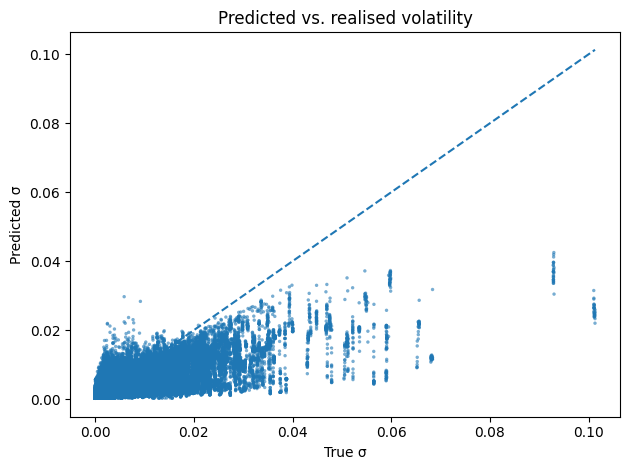

In [10]:
plt.figure()
plt.scatter(y_test, pred, s=6, alpha=0.6, edgecolor="none")
max_val = max(np.max(y_test), np.max(pred))
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.title("Predicted vs. realised volatility")
plt.xlabel("True σ")
plt.ylabel("Predicted σ")
plt.tight_layout()
plt.show()

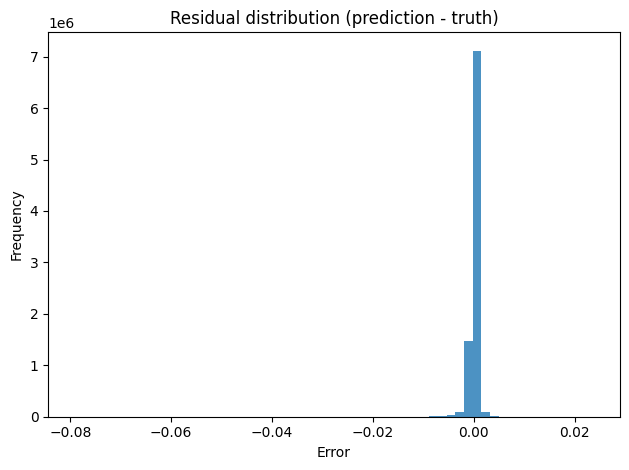

In [11]:
residuals = pred - y_test
plt.figure()
plt.hist(residuals, bins=60, alpha=0.8)
plt.title("Residual distribution (prediction - truth)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()